### Model Training

1.1 Import Data and Required Packages

Importing Necessary libraries

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/food.csv')

Display first five records

In [3]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [4]:
# Dropping order id  
df.drop(['Order_ID'],axis=1,inplace=True)

In [5]:
# Fill categorical columns with mode
for col in ['Weather', 'Traffic_Level', 'Time_of_Day']:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill numerical column with median
df['Courier_Experience_yrs'] = df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].median())

In [6]:
# List of numerical columns to check for outliers
num_cols = ['Delivery_Time_min', 'Distance_km', 'Preparation_Time_min']

# Loop through each numerical column and remove outliers using IQR
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Keep only rows within the bounds
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

Preparing X and Y variables

In [7]:
X = df.drop(columns=['Delivery_Time_min'],axis=1)

In [8]:
X.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0
1,16.42,Clear,Medium,Evening,Bike,20,2.0
2,9.52,Foggy,Low,Night,Scooter,28,1.0
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0
4,19.03,Clear,Low,Morning,Bike,16,5.0


In [9]:
print("Categories in 'weather' variable:     ",end=" " )
print(df['Weather'].unique())

print("Categories in 'traffic level' variable:  ",end=" ")
print(df['Traffic_Level'].unique())

print("Categories in 'time of day' variable:",end=" " )
print(df['Time_of_Day'].unique())

print("Categories in 'vehicle type' variable:     ",end=" " )
print(df['Vehicle_Type'].unique())

Categories in 'weather' variable:      ['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']
Categories in 'traffic level' variable:   ['Low' 'Medium' 'High']
Categories in 'time of day' variable: ['Afternoon' 'Evening' 'Night' 'Morning']
Categories in 'vehicle type' variable:      ['Scooter' 'Bike' 'Car']


In [10]:
y=df['Delivery_Time_min']

In [11]:
y.head()

0    43
1    84
2    59
3    37
4    68
Name: Delivery_Time_min, dtype: int64

In [12]:
df.isnull().sum()

Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

In [13]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(handle_unknown="ignore",sparse=False)

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [14]:
X = preprocessor.fit_transform(X)

c:\Users\kanna\Downloads\FoodDeliveryTimes\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
X.shape

(994, 18)

In [16]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((795, 18), (199, 18))

Create an Evaluate Function to give all metrics after model Training

In [17]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [18]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 9.8000
- Mean Absolute Error: 6.3933
- R2 Score: 0.7813
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 8.5828
- Mean Absolute Error: 5.5641
- R2 Score: 0.8513


Lasso
Model performance for Training set
- Root Mean Squared Error: 10.7137
- Mean Absolute Error: 7.3002
- R2 Score: 0.7387
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 9.6532
- Mean Absolute Error: 6.7658
- R2 Score: 0.8119


Ridge
Model performance for Training set
- Root Mean Squared Error: 9.7990
- Mean Absolute Error: 6.3902
- R2 Score: 0.7814
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 8.5982
- Mean Absolute Error: 5.5836
- R2 Score: 0.8508


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 9.9040
- Mean Absolute Error: 7.4478
- R2 Score: 0.7767
----------------------

In [19]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Linear Regression,0.851322
2,Ridge,0.850788
7,CatBoosting Regressor,0.819819
5,Random Forest Regressor,0.813855
1,Lasso,0.811922
6,XGBRegressor,0.771549
3,K-Neighbors Regressor,0.738934
4,Decision Tree,0.695790
8,AdaBoost Regressor,0.594950


Linear Regression

In [20]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 85.13


Plot y_pred and y_test

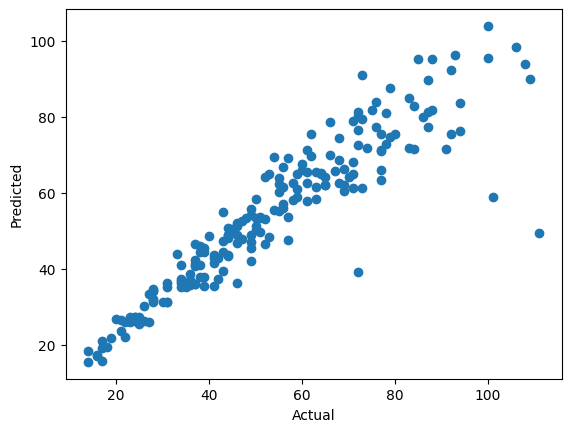

In [21]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

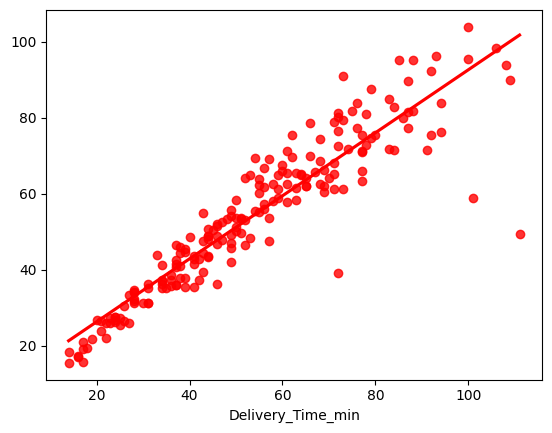

In [22]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

Difference between Actual and Predicted Values

In [23]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
925,28,32.152344,-4.152344
529,57,69.109375,-12.109375
571,63,61.500000,1.500000
660,44,43.234375,0.765625
932,34,36.253906,-2.253906
...,...,...,...
490,68,62.531250,5.468750
455,28,31.164062,-3.164062
66,68,68.535156,-0.535156
143,37,42.414062,-5.414062
